# TEST & XAI
This programme is used to test the models with metrics.    
With Explainable AI (XAI) techniques: 
- we will compare/visualize the attention layer of each model
- we test prediction and analyse token

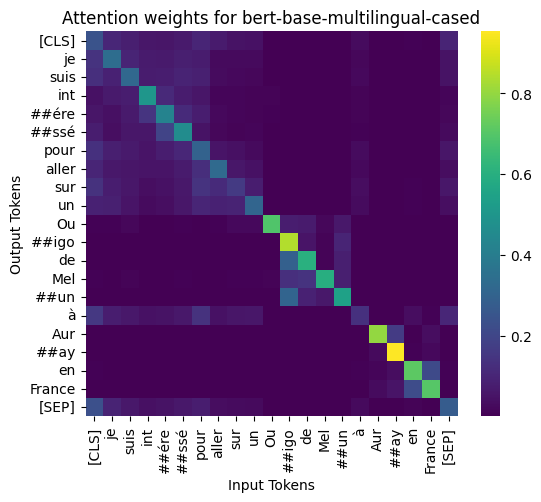

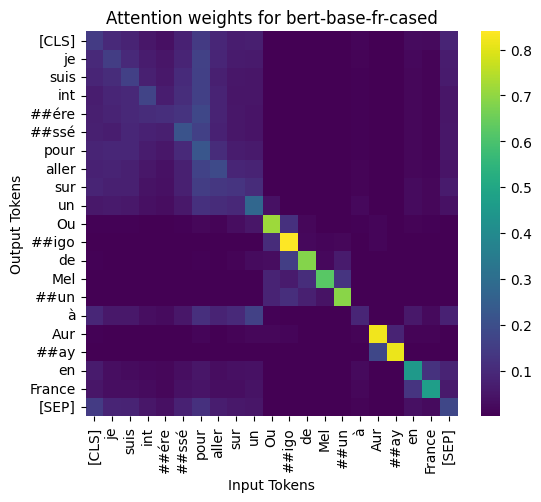

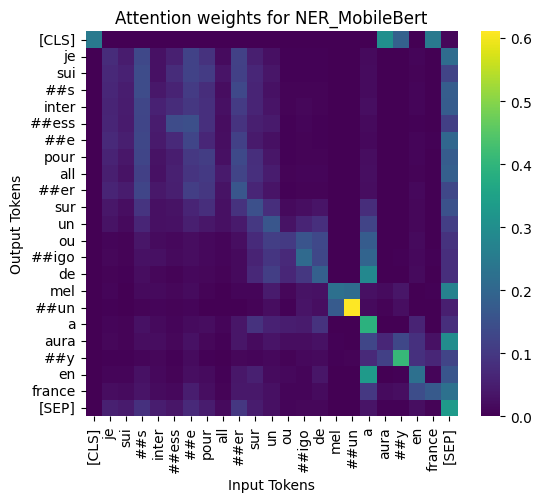

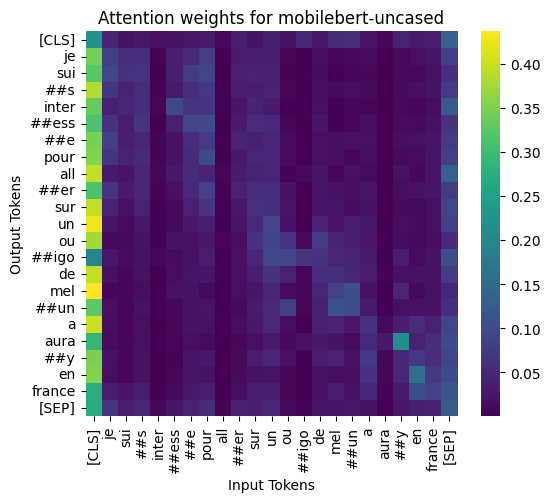

In [3]:
import os
import tensorflow as tf
from transformers import AutoConfig, BertTokenizerFast, MobileBertTokenizerFast, MobileBertTokenizer, TFBertForTokenClassification, TFMobileBertForTokenClassification, AutoConfig

from utils import visualize_attention_heatmap

from transformers import logging as hf_logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
hf_logging.set_verbosity_error()


phrase_test = "je suis intéressé pour aller sur un Ouigo de Melun à Auray en France"

# Accès all modeles
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..', '..', 'model', 'models')
models = {model_name: os.path.join(base_dir, model_name) for model_name in os.listdir(base_dir) 
          if os.path.isdir(os.path.join(base_dir, model_name))}

tokenizers = {}
loaded_models = {}

for name, path in models.items():
    # config = AutoConfig.from_pretrained(path, output_attentions=True)
    if name in ["", "NER_MobileBert", "mobilebert-uncased"]:
        tokenizer = MobileBertTokenizerFast.from_pretrained(path)
        model = TFMobileBertForTokenClassification.from_pretrained(path)
    else:
        tokenizer = BertTokenizerFast.from_pretrained(path)
        model = TFBertForTokenClassification.from_pretrained(path)

    tokenizers[name] = tokenizer
    loaded_models[name] = model


# visualize attention weights
def visualize_attention(text, model, tokenizer, model_name):
    inputs = tokenizer.encode_plus(text, return_tensors='tf')
    outputs = model(**inputs, output_attentions=True)
    # print("outputs attentions:", outputs.attentions)
    attentions = outputs.attentions  # Tuple de tenseurs

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].numpy())

    attention = attentions[-1]  # last layer
    attention = tf.squeeze(attention, axis=0)  # delete the batch dimension

    # average attention weights over heads
    attention = tf.reduce_mean(attention, axis=0).numpy()

    # Heatmap
    visualize_attention_heatmap(attention, tokens, model_name)


visualize_attention(phrase_test, loaded_models["bert-base-multilingual-cased"], tokenizers["bert-base-multilingual-cased"], "bert-base-multilingual-cased")
visualize_attention(phrase_test, loaded_models["bert-base-fr-cased"], tokenizers["bert-base-fr-cased"], "bert-base-fr-cased")
visualize_attention(phrase_test, loaded_models["NER_MobileBert"], tokenizers["NER_MobileBert"], "NER_MobileBert")
visualize_attention(phrase_test, loaded_models["mobilebert-uncased"], tokenizers["mobilebert-uncased"], "mobilebert-uncased")





In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from utils import encode_data
from transformers import BertTokenizerFast, MobileBertTokenizerFast, TFBertForTokenClassification, TFMobileBertForTokenClassification, AutoConfig

from transformers import logging as hf_logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
hf_logging.set_verbosity_error()

test_phrases = [
    {'Phrase': "je suis intéressé pour aller de Melun à Auray en France", 'Départ': 'Melun', 'Arrivée': "Auray"},
    {'Phrase': "Depuis Paris, je veux aller à Albert pour boire un Monaco", 'Départ': 'Paris', 'Arrivée': "Albert"}
]
# Access all models
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..', '..', 'model', 'models')
models = {
    model_name: os.path.join(base_dir, model_name)
    for model_name in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, model_name))
}

# Encode data with corresponding labels
unique_labels = ['O', 'B-DEP', 'I-DEP', 'B-ARR', 'I-ARR']
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

tokenizers = {}
loaded_models = {}

for model_name, model_path in models.items():
    print(f"Loading model and tokenizer for: {model_name}")
    config = AutoConfig.from_pretrained(model_path, output_attentions=True)
    if model_name in ["NER_MobileBert", "mobilebert-uncased"]:
        tokenizer = MobileBertTokenizerFast.from_pretrained(model_path, config=config)
        model = TFMobileBertForTokenClassification.from_pretrained(model_path, config=config)
    else:
        model = TFBertForTokenClassification.from_pretrained(model_path, config=config)
        tokenizer = BertTokenizerFast.from_pretrained(model_path)
    
    tokenizers[model_name] = tokenizer
    loaded_models[model_name] = model

# Iterate over all models and test phrases
for model_name in models:
    print(f"\n---> Processing with model: {model_name}")
    model = loaded_models[model_name]
    tokenizer = tokenizers[model_name]

    for test_phrase in test_phrases:
        encoded_data_with_tokenizer = encode_data(pd.DataFrame([test_phrase]), tokenizer, label_encoder)
        new_tokens, new_labels = encoded_data_with_tokenizer

        new_predictions = model.predict(new_tokens).logits
        new_predicted_labels = np.argmax(new_predictions, axis=-1)

        predicted_label_names = [label_encoder.inverse_transform([label_id])[0] for label_id in new_predicted_labels[0]]
        get_true_labels = [label_encoder.inverse_transform([label_id])[0] for label_id in new_labels[0]]

        prediction_success = predicted_label_names == get_true_labels
        print(f"\n// Prediction success for '{test_phrase['Phrase']}':", prediction_success)

        # Results
        tokens_with_special_tokens = tokenizer.convert_ids_to_tokens(new_tokens[0])

        print("\nResult:")
        print("{:<14} {:<10} {:<8} {:<6}".format("Token", "Predicted", "True", "Result"))
        print("-" * 42)

        for token, predicted_label, true_label in zip(tokens_with_special_tokens, predicted_label_names, get_true_labels):
            result = "✔️" if predicted_label == true_label else "❌"
            print("{:<14} {:<10} {:<8} {:<6}".format(token, predicted_label, true_label, result))

Loading model and tokenizer for: bert-base-fr-cased
Loading model and tokenizer for: bert-base-multilingual-cased
Loading model and tokenizer for: mobilebert-uncased
Loading model and tokenizer for: NER_MobileBert

---> Processing with model: bert-base-fr-cased

// Encoding completed
1/1 [==============================] - 6s 6s/step

// Prediction success for 'je suis intéressé pour aller de Melun à Auray en France': True

Result:
Token          Predicted  True     Result
------------------------------------------
[CLS]          O          O        ✔️    
je             O          O        ✔️    
suis           O          O        ✔️    
int            O          O        ✔️    
##ére          O          O        ✔️    
##ssé          O          O        ✔️    
pour           O          O        ✔️    
aller          O          O        ✔️    
de             O          O        ✔️    
Mel            B-DEP      B-DEP    ✔️    
##un           I-DEP      I-DEP    ✔️    
à              O  

### Conclusion



The 2 Bert base models are more efficient than the 2 mobileBert